# **Project_06_Building LSTM Model: Lyrics Generator With Keras**

## **0. 평가문항	상세기준**
---

1. 가사 텍스트 생성 모델이 정상적으로 동작하는가?

  - 텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?
2. 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가?

  - 특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?
3. 텍스트 생성모델이 안정적으로 학습되었는가?

  - 텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?


## **1. 데이터 불러오기 및 확인**
---

### **1-1. 라이브러리, 클래스, 함수 불러오기**

In [ ]:
############################################## 라이브러리 불러오기 #####################################################
# !pip install pmdarima
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.5f}'.format #지수표현식말고 실수로 표현
import platform
import random
import warnings
import statsmodels
import math
import tensorflow as tf
from pathlib import Path
import glob
import re
warnings.filterwarnings(action = "ignore")
# 시각화

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

# 모델 성능 평가 지표, 학습데이터 분리 
from sklearn.model_selection import train_test_split

# 구글드라이브 
from google.colab import drive
import os


plt.rcParams['axes.unicode_minus'] = False 
# fm._rebuild()



### **1-2. 데이터 불러오기**

In [ ]:
############################## 데이터 경로지정  ##############################
# 구글드라이브 
from google.colab import drive
import os
root = "/content/drive"
drive.mount(root, force_remount=True)

googledrive_path = os.path.join(root,"MyDrive/github/ML-DL-Project")
project_dir = "Project_06_Building LSTM Model: Lyrics Generator"
data_path = os.path.join(root,googledrive_path,project_dir,"src/data")
print('data path: ',data_path)

Mounted at /content/drive
data path:  /content/drive/MyDrive/github/ML-DL-Project/Project_06_작사가/src/data


In [ ]:
############################## 데이터 불러오는 함수 정의  ##############################

def load_text_data(path = data_path):
  # 1) glob 를 활용하여 모든 txt 파일을 읽어온 후,
  text_file_list = glob.glob(data_path+'/*.txt')
  # 2) 라인 단위로 끊어서 list 형태로 읽어온다.
  raw_corpus = [open(txt_file, "r").read().splitlines() for txt_file in text_file_list ]
  raw_corpus = sum(raw_corpus, []) # 중첩리스트 flatten하게 만들기 
  return raw_corpus


In [ ]:
############################## 데이터 불러오기 ##############################
raw_corpus = load_text_data(data_path)

print("데이터 크기:", len(raw_corpus),"\n")
print("{:=^75}".format(" [데이터 일부 확인] "))
for idx, sentence in enumerate(raw_corpus[:20]):
    print(idx,sentence)

데이터 크기: 187088 

=============================== [데이터 일부 확인] ===============================
0 Let's stay together I, I'm I'm so in love with you
1 Whatever you want to do
2 Is all right with me
3 Cause you make me feel so brand new
4 And I want to spend my life with you Let me say that since, baby, since we've been together
5 Loving you forever
6 Is what I need
7 Let me, be the one you come running to
8 I'll never be untrue Oh baby
9 Let's, let's stay together (gether)
10 Lovin' you whether, whether
11 Times are good or bad, happy or sad
12 Oh, oh, oh, oh, yeah
13 Whether times are good or bad, happy or sad Why, why some people break up
14 Then turn around and make up
15 I just can't see
16 You'd never do that to me (would you, baby)
17 Staying around you is all I see
18 (Here's what I want us do) Let's, we oughta stay together (gether)
19 Loving you whether, whether



위에서 본 데이터의 문장 일부를 출력해보니 특수문자가 들어가있는 문장들이 존재한다. 또한 공백으로만 이루어져있거나, 단어하나로만 이루어진 문장들이 존재하는것을 확인 할 수 있다. 이러한 요소는 앞으로 진행할 데이터 토큰화 과정에서 약간의 문제로 작용할 수 있기에 불필요한문자들을 제거하는 전처리과정을 진행하기로 한다.

## **2. 데이터 전처리**

### **2-1. 정규표현식을 활용한 불필요한 문자 필터링**

In [ ]:
##############################  공백,특수문자,문장부호,대소문자 정제하는 함수 정의  ##############################

# 1. 소문자로 바꾸고, 양쪽 공백을 지운다
# 2. 특수문자 양쪽에 공백을 넣고
# 3. 여러개의 공백은 하나의 공백으로 바꾼다
# 4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾼다
# 5. 다시 양쪽 공백을 지운다
# 6. 문장 시작에는 <start>, 끝에는 <end>를 추가한다

def preprocess_sentence(sentence):
  if sentence[-1] == ":" : sentence = ""
  sentence = sentence.lower().strip() # 1
  sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
  sentence = re.sub(r'[" "]+', " ", sentence) # 3
  sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
  sentence = sentence.strip() # 5
  sentence = '<start> ' + sentence + ' <end>' # 6
  return sentence 

In [ ]:
##############################  정제데이터 구축  ##############################
corpus = [preprocess_sentence(sentence) for sentence in raw_corpus if len(sentence) != 0 ]
corpus[:30]

['<start> let s stay together i , i m i m so in love with you <end>',
 '<start> whatever you want to do <end>',
 '<start> is all right with me <end>',
 '<start> cause you make me feel so brand new <end>',
 '<start> and i want to spend my life with you let me say that since , baby , since we ve been together <end>',
 '<start> loving you forever <end>',
 '<start> is what i need <end>',
 '<start> let me , be the one you come running to <end>',
 '<start> i ll never be untrue oh baby <end>',
 '<start> let s , let s stay together gether <end>',
 '<start> lovin you whether , whether <end>',
 '<start> times are good or bad , happy or sad <end>',
 '<start> oh , oh , oh , oh , yeah <end>',
 '<start> whether times are good or bad , happy or sad why , why some people break up <end>',
 '<start> then turn around and make up <end>',
 '<start> i just can t see <end>',
 '<start> you d never do that to me would you , baby <end>',
 '<start> staying around you is all i see <end>',
 '<start> here s what i 

짜잔, 지저분한 문장을 넣어도 예쁘게 변환해 주는 정제 함수가 완성되었습니다! 보너스로 이전 스텝에서 배운 <start> <end> 도 추가했습니다.

그러면 우리가 구축해야 할 데이터셋은 어떤 모양이 될까요?

이전 스텝에서 봤던 예를 떠올려 봅시다.

- 언어 모델의 입력 문장 :  <start> 나는 밥을 먹었다
- 언어 모델의 출력 문장 : 나는 밥을 먹었다 <end>

자연어처리 분야에서 모델의 입력이 되는 문장을 소스 문장(Source Sentence) , 정답 역할을 하게 될 모델의 출력 문장을 타겟 문장(Target Sentence) 라고 관례적으로 부릅니다. 각각 X_train, y_train 에 해당한다고 할 수 있겠죠?

그렇다면 우리는 위에서 만든 정제 함수를 통해 만든 데이터셋에서 토큰화를 진행한 후 끝 단어 <end>를 없애면 소스 문장, 첫 단어 <start>를 없애면 타겟 문장이 되겠죠? 이 정제 함수를 활용해서 아래와 같이 정제 데이터를 구축합니다!

### **2-2. 데이터 토큰화 & 텐서 변환**

이제 데이터는 완벽하게 준비가 된 것 같네요!

자, 새로운 언어를 배우는 상상을 해봅시다. 영어를 전혀 모르던 그 때로 돌아가서, 다시 영어를 배우려면 어떻게 해야 할까요? 영한사전 을 허리춤에 끼고 문장 속 단어를 하나하나 찾아가며 한국어 해석 을 적겠죠? 이 아이디어는 인공지능에게도 똑같이 적용됩니다. 배우고자 하는 언어 를 모국어로 표현 을 해야 공부를 할 수 있어요.

인공지능의 모국어라면 단연 숫자 겠죠. 우리는 가르칠 언어(데이터)를 숫자로 변환해서 인공지능에게 줄 겁니다. 이에 필요한 것은 사전 ! 굳이 명명하자면... 데숫사전...?

텐서플로우는 자연어 처리를 위한 여러 가지 모듈을 제공하는데, 우리도 그 모듈을 십분 활용할 겁니다! 아래에서 활용하게 될 tf.keras.preprocessing.text.Tokenizer 패키지는 정제된 데이터를 토큰화하고, 단어 사전(vocabulary 또는 dictionary라고 칭함)을 만들어주며, 데이터를 숫자로 변환까지 한 방에 해줍니다. 이 과정을 벡터화(vectorize) 라 하며, 숫자로 변환된 데이터를 텐서(tensor) 라고 칭합니다. 우리가 사용하는 텐서플로우로 만든 모델의 입출력 데이터는 실제로는 모두 이런 텐서로 변환되어 처리되는 것입니다.

In [ ]:
##############################  데이터 토큰화를 위한 함수 정의  ############################## 

# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 12,000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 12,000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    # 토큰화 했을 때 토큰의 개수가 20개를 넘어가는 문장을 학습 데이터에서 제외하기 
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=20)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer


In [ ]:
##############################  토큰화된 텐서 데이터 생성 및 출력  ############################## 
tensor, tokenizer = tokenize(corpus)
print(tensor[:3, :10]) #생성된 텐서 데이터를 3번째 행, 10번째 열까지만 출력해 봅시다.

[[   2   63   16 ...    0    0    0]
 [   2  598    7 ...    0    0    0]
 [   2   26   24 ...    0    0    0]
 ...
 [   2  211    3 ...    0    0    0]
 [   2  400    9 ...    0    0    0]
 [   2    9 1296 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f1a28265290>
[[  2  63  16 222 283   5   4   5  22   5]
 [  2 598   7  62  10  47   3   0   0   0]
 [  2  26  24  84  31  12   3   0   0   0]]


텐서 데이터는 모두 정수로 이루어져 있습니다. 이 숫자는 다름 아니라, tokenizer에 구축된 단어 사전의 인덱스입니다. 단어 사전이 어떻게 구축되었는지 아래와 같이 확인해 봅시다.



In [ ]:
##############################  tokenizer에 구축된 단어 사전 확인  ############################## 

for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


어떻습니까? 2번 인덱스가 바로 <start>였습니다. 왜 모든 행이 2로 시작하는지 이해할 수 있겠습니다.

이제 생성된 텐서를 소스와 타겟으로 분리하여 모델이 학습할 수 있게 하겠습니다. 이 과정도 텐서플로우 가 제공하는 모듈을 사용할 것이니, 어떻게 사용하는지만 눈여겨 봐둡시다.

텐서 출력부에서 행 뒤쪽에 0이 많이 나온 부분은 정해진 입력 시퀀스 길이보다 문장이 짧을 경우 0으로 패딩(padding)을 채워 넣은 것입니다. 사전에는 없지만 0은 바로 패딩 문자 <pad>가 될 것입니다.

In [ ]:
##############################  텐서를 소스와 타겟으로 분리  ############################## 

# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2  63  16 222 283   5   4   5  22   5  22  30  14  33  31   7   3   0
   0]
[ 63  16 222 283   5   4   5  22   5  22  30  14  33  31   7   3   0   0
   0]


corpus 내의 첫 번째 문장에 대해 생성된 소스와 타겟 문장을 확인해 보았습니다. 예상대로 소스는 2(<start>)에서 시작해서 3(<end>)으로 끝난 후 0(<pad>)로 채워져 있습니다. 하지만 타겟은 2로 시작하지 않고 소스를 왼쪽으로 한 칸 시프트 한 형태를 가지고 있습니다.

### **2-3. 데이터셋(tf.data.Dataset) 객체 생성**

마지막으로 우리는 데이터셋 객체를 생성할 것입니다. 그동안 우리는 model.fit(x_train, y_train, ...) 형태로 Numpy Array 데이터셋을 생성하여 model에 제공하는 형태의 학습을 많이 진행해 왔습니다. 그러나 텐서플로우를 활용할 경우 텐서로 생성된 데이터를 이용해 tf.data.Dataset객체를 생성하는 방법을 흔히 사용합니다. tf.data.Dataset객체는 텐서플로우에서 사용할 경우 데이터 입력 파이프라인을 통한 속도 개선 및 각종 편의 기능을 제공하므로 꼭 사용법을 알아 두시기를 권합니다. 우리는 이미 데이터셋을 텐서 형태로 생성해 두었으므로, tf.data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체를 생성할 것입니다.

In [ ]:
################### 학습, 테스트 데이터 나누기  ###############
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=121)



print('Source Train: ', enc_train.shape)
print('Target Train: ', dec_train.shape)

Source Train:  (140788, 19)
Target Train:  (140788, 19)


In [ ]:
##############################  tf.data.Dataset.from_tensor_slices() : tf.data.Dataset객체를 생성  ############################## 

BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
# steps_per_epoch = len(src_input) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 19), dtype=tf.int32, name=None), TensorSpec(shape=(256, 19), dtype=tf.int32, name=None))>

dataset을 얻음으로써 데이터 다듬기 과정은 끝났습니다. tf.data.Dataset에서 제공하는 shuffle(), batch() 등 다양한 데이터셋 관련 기능을 손쉽게 이용할 수 있게 되었군요.

이 모든 일련의 과정을 텐서플로우에서의 데이터 전처리 라 칭합니다!

## **3. 모델 구현 및 평가**
---

### **3-1. 모델 생성**

우리가 만들 모델의 구조도는 아래와 같습니다.

<img src="./content/drive/MyDrive/github/ML-DL-Project/Project_06_작사가/src/img/model_structure.png" ></img>

우리가 만들 모델은 tf.keras.Model을 Subclassing하는 방식으로 만들 것입니다. 위 그림에서 설명한 것처럼 우리가 만들 모델에는 1개의 Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있습니다.
각 레이어의 기능을 확실히 이해하는 것은 나중에 하고, 지금은 구조도에 설명된 정도의 간단한 이해만 가지고 갑시다.  
각 레이어의 기능을 확실히 이해하는 것은 나중에 하고, 지금은 구조도에 설명된 정도의 간단한 이해만 가지고 갑시다.



In [ ]:
##############################  모델구조  ############################## 


class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        # representation: 의미 벡터 공간에서 단어의 추상적 표현으로 사용되도록 
            # 입력텐서의 단어사전 인덱스값을 해당 인덱스번째의 워드 벡터로 밤꿔줌 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)

    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out




embedding_size = 20 
hidden_size = 2000 


model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

텍스트 분류 모델을 다루어 보셨다면 Embedding 레이어의 역할에 대해서는 낯설지 않을 것입니다. 우리 입력 텐서에는 단어 사전의 인덱스가 들어 있습니다. Embedding 레이어는 이 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔 줍니다. 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현(representation)으로 사용됩니다.

위 코드에서 embedding_size 는 워드 벡터의 차원수, 즉 단어가 추상적으로 표현되는 크기입니다. 만약 그 크기가 2라면 예를 들어

차갑다: [0.0, 1.0]
뜨겁다: [1.0, 0.0]
미지근하다: [0.5, 0.5]
정도의 구분이 가능하겠군요. 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만, 그만큼 충분한 데이터가 주어지지 않으면 오히려 혼란만을 야기할 수 있습니다. 이번 실습에서는 256이 적당해 보이네요.

LSTM 레이어의 hidden state 의 차원수인 hidden_size 도 같은 맥락입니다. hidden_size 는 모델에 얼마나 많은 일꾼을 둘 것인가? 로 이해해도 크게 엇나가지 않습니다. 그 일꾼들은 모두 같은 데이터를 보고 각자의 생각을 가지는데, 역시 충분한 데이터가 주어지면 올바른 결정을 내리겠지만 그렇지 않으면 배가 산으로 갈 뿐 입니다. 이번 실습에는 1024가 적당해보이는군요.





### **3-2. 모델 학습**


#### **3-2-1. 모델 구조 확인**


우리의 model은 아직 제대로 build되지 않았습니다. model.compile()을 호출한 적도 없고, 아직 model의 입력 텐서가 무엇인지 제대로 지정해 주지도 않았기 때문입니다.
그런 경우 아래와 같이 model에 데이터를 아주 조금 태워 보는 것도 방법입니다. model의 input shape가 결정되면서 model.build()가 자동으로 호출됩니다.

In [ ]:
##############################  모델구조 확인을 위해 하나의 배치만 가지고오기  ############################## 

for src_sample, tgt_sample in dataset.take(1): break

model(src_sample) # 한 배치만 불러온 데이터를 모델에 넣어봄

<tf.Tensor: shape=(256, 19, 12001), dtype=float32, numpy=
array([[[-1.67036637e-06,  2.37896347e-06, -2.94493420e-05, ...,
          4.08373126e-05,  1.57522427e-05, -2.84374109e-05],
        [ 2.03639520e-05, -4.18423515e-05, -1.36453935e-04, ...,
          7.67088659e-06, -7.93689469e-06, -9.01278472e-05],
        [-2.70104720e-05, -4.12160989e-05, -2.18690038e-04, ...,
         -3.33810603e-05, -2.11230545e-05, -1.42800593e-04],
        ...,
        [ 2.00014274e-05, -5.09017962e-04,  2.60916160e-04, ...,
          2.86882569e-04, -2.76135514e-04,  1.18806413e-04],
        [-2.22591152e-05, -6.05480105e-04,  2.08397847e-04, ...,
          3.02605506e-04, -3.39197082e-04,  1.48113395e-04],
        [-6.37937483e-05, -6.92480942e-04,  1.64300320e-04, ...,
          3.06288683e-04, -3.94686213e-04,  1.79276380e-04]],

       [[-1.67036637e-06,  2.37896347e-06, -2.94493420e-05, ...,
          4.08373126e-05,  1.57522427e-05, -2.84374109e-05],
        [ 2.53311664e-05,  1.23425139e-04, -5

> 모델의 최종 출력 텐서 shape를 유심히 보면 shape=(256, 19, 12001)임을 알 수 있다. 이것이 무엇인지 하나씩 살펴보도록 하겠다. 12001은 Dense 레이어의 출력 차원수입니다. 12001개의 단어 중 어느 단어의 확률이 가장 높을지를 모델링해야 하기 때문입니다.
256은 이전 스텝에서 지정한 배치 사이즈입니다. dataset.take(1)를 통해서 1개의 배치, 즉 256개의 문장 데이터를 가져온 것입니다.

그렇다면 19는 무엇을 의미할까요? 비밀은 바로 tf.keras.layers.LSTM(hidden_size, return_sequences=True)로 호출한 LSTM 레이어에서 return_sequences=True이라고 지정한 부분에 있습니다. 즉, LSTM은 자신에게 입력된 시퀀스의 길이만큼 동일한 길이의 시퀀스를 출력한다는 의미입니다. 만약 return_sequences=False였다면 LSTM 레이어는 1개의 벡터만 출력했을 것입니다.

그런데 문제는, 우리의 모델은 입력 데이터의 시퀀스 길이가 얼마인지 모른다는 점입니다. 모델을 만들면서 알려준 적도 없습니다. 그럼 19는 언제 알게된 것일까요? 네, 그렇습니다. 데이터를 입력받으면서 비로소 알게 된 것입니다. 우리 데이터셋의 max_len이 19로 맞춰져 있었던 것입니다.

In [ ]:
model.summary()

Model: "text_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  240020    
                                                                 
 lstm (LSTM)                 multiple                  16168000  
                                                                 
 lstm_1 (LSTM)               multiple                  32008000  
                                                                 
 dense (Dense)               multiple                  24014001  
                                                                 
Total params: 72,430,021
Trainable params: 72,430,021
Non-trainable params: 0
_________________________________________________________________


이제 드디어 model.summary()를 호출할 수 있게 되었습니다. 그런데 호출해 보니 그동안 많이 보았던 것과는 다른 점이 있습니다. 우리가 궁금했던 Output Shape를 정확하게 알려주지 않습니다. 바로 위에서 설명한 이유 때문입니다. 우리의 모델은 입력 시퀀스의 길이를 모르기 때문에 Output Shape를 특정할 수 없는 것입니다.

하지만 모델의 파라미터 사이즈는 측정됩니다. 대략 22million 정도 되는군요. 참고로 서두에 소개했던 GPT-2의 파라미터 사이즈는, 1.5billion입니다. 우리 모델의 100배까지는 안되더라도 수십배가 넘는군요. 놀라지 마세요. GPT-3의 파라미터 사이즈는 GPT-2의 100배니까요.

#### **3-2-2. 모델 학습**


이제 모델이 학습할 준비가 완료되었습니다. 아래 코드를 실행해 모델을 학습시켜보세요!

> 학습엔 15분 정도 소요됩니다(GPU 환경 기준). 간단한 스트레칭과 커피 한 잔을 만들어 오기에 적당한 시간이죠.
혹시라도 학습에 지나치게 많은 시간이 소요된다면 tf.test.is_gpu_available() 소스를 실행해 텐서플로우가 GPU를 잘 사용하고 있는지 확인하시길 바랍니다!



In [ ]:
###################### 
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다
optimizer = tf.keras.optimizers.Adam()
# tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06)

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)
epochs = 10


model.compile(loss=loss, optimizer=optimizer)
history = model.fit(enc_train, 
          dec_train, 
          epochs=epochs,
          batch_size=256,
          validation_data=(enc_val, dec_val), 
          verbose=1)


Epoch 1/10
550/550 [==============================] - 182s 323ms/step - loss: 3.0898 - val_loss: 2.6975
Epoch 2/10
550/550 [==============================] - 177s 321ms/step - loss: 2.5709 - val_loss: 2.4839
Epoch 3/10
550/550 [==============================] - 177s 321ms/step - loss: 2.3928 - val_loss: 2.3722
Epoch 4/10
550/550 [==============================] - 177s 321ms/step - loss: 2.2534 - val_loss: 2.2884
Epoch 5/10
550/550 [==============================] - 177s 321ms/step - loss: 2.1196 - val_loss: 2.2091
Epoch 6/10
550/550 [==============================] - 177s 321ms/step - loss: 1.9816 - val_loss: 2.1451
Epoch 7/10
550/550 [==============================] - 176s 320ms/step - loss: 1.8402 - val_loss: 2.0823
Epoch 8/10
550/550 [==============================] - 176s 320ms/step - loss: 1.6980 - val_loss: 2.0346
Epoch 9/10
550/550 [==============================] - 176s 321ms/step - loss: 1.5576 - val_loss: 1.9944
Epoch 10/10
550/550 [==============================] - 177s 321m

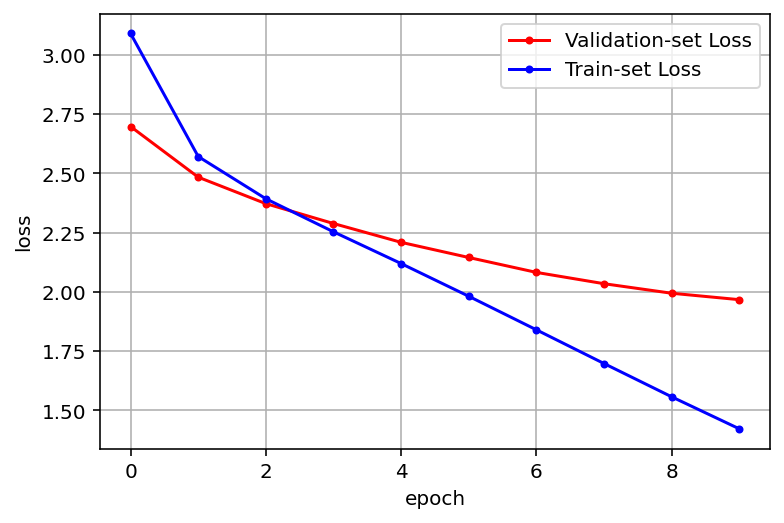

In [ ]:

 #################### epoch 별 loss 시각화 #################################################
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Loss는 모델이 오답을 만들고 있는 정도라고 생각하셔도 좋습니다(그렇다고 Loss가 1일 때 99%를 맞추고 있다는 의미는 아닙니다). 오답률이 감소하고 있으니 학습이 잘 진행되고 있다 고 해석할 수 있죠!

학습이 완료되었다면 이제 모델을 평가해 봅시다.

### **3-3. 모델 평가**


모델이 작문을 잘하는지 컴퓨터 알고리즘이 평가하는 것은 무리가 있습니다. 만약에 그게 가능했다면 우리가 지금껏 해온 독후감 숙제를 컴퓨터가 채점했겠죠? 우선 작문을 잘했다는 기준마저도 사람마다 다릅니다. 그래서 작문을 잘했는지를 정량적으로 측정할 이론 조차도 없습니다. 그래서 작문을 잘 했는지 컴퓨터가 판단할 방법을 만들 수도 없죠.

만약 작문이 아닌 요약, 문제 풀이, 번역처럼 비교적 정량적으로 측정할 대상이 있는 경우라면 조금 가능할 지도 모릅니다. 그래서 BLEU나 ROUGE 등의 평가 방법이 제안되고 많이 이용됩니다. 대체로 자연어 처리에서 결과를 평가할 때는 어떤 단어가 포함 되었는지를 바탕으로 측정하는데요. 요약이나 문제풀이, 번역과 같은 작업에는 핵심 단어가 포함되었는지만 측정해도 어느 정도 정량적인 평가가 되기 때문에 가능한 것이죠. 이번에 사용하지는 않지만 자연어 처리에서는 많이 사용되는 평가 방법이니 이름은 익혀두세요.

이번처럼 작문 모델을 평가하는 가장 확실한 방법은 작문을 시켜보고 사람이 평가하는 겁니다.

아래 generate_text 함수는 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행하게 합니다.

In [ ]:

##############################  작문수행하는 함수 정의  ############################## 
# 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문

def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

텍스트를 생성하는 함수 안을 들여다보면 while문이 하나 자리 잡고 있는 것을 볼 수 있습니다. 왜 그럴까요?

학습 단계에서 우리는 이런 while 문이 필요 없었습니다. 소스 문장과 타겟 문장이 있었고, 우리는 소스 문장을 모델에 입력해서 나온 결과를 타겟 문장과 직접 비교하면 그만이었습니다.
그러나 텍스트를 실제로 생성해야 하는 시점에서, 우리에게는 2가지가 없습니다. 하나는 타겟 문장입니다. 또 하나는 무엇이냐 하면, 소스 문장입니다. 생각해 보면 우리는 텍스트 생성 태스크를 위해 테스트 데이터셋을 따로 생성한 적이 없습니다.

generate_text() 함수에서 init_sentence를 인자로 받고는 있습니다. 이렇게 받은 인자를 일단 텐서로 만들고 있습니다. 디폴트로는 <start> 단어 하나만 받는군요.

while의 첫 번째 루프에서 test_tensor에 <start> 하나만 들어갔다고 합시다. 우리의 모델이 출력으로 7001개의 단어 중 A를 골랐다고 합시다.
while의 두 번째 루프에서 test_tensor에는 <start> A가 들어갑니다. 그래서 우리의 모델이 그다음 B를 골랐다고 합시다.
while의 세 번째 루프에서 test_tensor에는 <start> A B가 들어갑니다. 그래서..... (이하 후략)

In [ ]:
##############################  작문수행 함수 실행  ############################## 
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m not gonna crack <end> '

In [24]:
generate_text(model, tokenizer, init_sentence="<start> i am", max_len=20)

'<start> i am not throwing away my shot <end> '

In [28]:
generate_text(model, tokenizer, init_sentence="<start> your love", max_len=20)

'<start> your love is fadin <end> '

## **4. 회고**


## **4. loss를 위한 노력들**
1. 전처리 수정
  - 히스토그램으로 단어의 수를 보고 특정 갯수에 치우친것들만 뽑아내거나
  - 우리가 예측하고자하는게 i love이니까 세 단어 이상으로 이루어져야하니 두단어로만 이루어진것을 삭제
  - 불용어 제거
  - 이런 전처리하는 함수 찾아보자 ! 

2.  lstm 하이퍼 파라미터 수정
  - embedding 
  - hidden_size
  - max_len 등 
  - dense 레이어 의 output 갯수 수정
  - optimizer 변경 ( compile 부분)
3. GridSearchCV 
  - 2번의 하이퍼 파라미터를 여러개 설정해서 하이퍼파라미터 튜닝 
  - 교차검증  
  - 케라스튜너 검색해보기 https://tykimos.github.io/2019/05/10/KerasTuner/
4. layer 추가& 수정
  - dense 층 추가
  - 과적합 방지 기법 사용 (drop out, batchnormalization)
5. 참고사이트
  -  [신경망 튜닝](https://velog.io/@qksekf/%EB%94%A5%EB%9F%AC%EB%8B%9D-%ED%95%98%EC%9D%B4%ED%8D%BC-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-%ED%8A%9C%EB%8B%9DETF-Keras-Tuner)
  - [자연어처리입문](https://wikidocs.net/36033)
